In [1]:
!git clone https://github.com/Leejunho123/deep-learning-from-scratch-3.git
%cd /content/deep-learning-from-scratch-3

Cloning into 'deep-learning-from-scratch-3'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 2104 (delta 1), reused 0 (delta 0), pack-reused 2097
Receiving objects: 100% (2104/2104), 34.94 MiB | 20.92 MiB/s, done.
Resolving deltas: 100% (1445/1445), done.
/content/deep-learning-from-scratch-3


## 59 RNN을 활용한 시계열 데이터 처리
+ 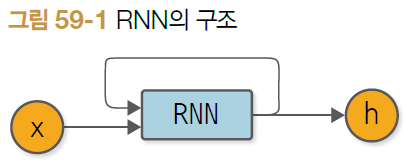
+ 순환 구조 때문에 RNN의 출력은 자신에게 피드백 됨. 따라서 상태를 가지게 됨 데이터가 입력되면 상태가 갱신되고 상태가 출력에 영향을 줌(h)

### 59.1 RNN 계층 구현
+ 순전파 식
+ 시계열 데이터 xt
+ 은닉 상태 ht

+ 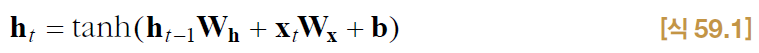

In [ ]:
class RNN(Layer):
  def __init__(self, hidden_size, in_size=None):
    super().__init()
    self.x2h = Linear(hidden_size, in_size=in_size)
    self.h2h = Linear(hidden_size, in_size=in_size, nobias=True)
    self.h = None

  def reset_state(self):
    self.h = None

  def forward(self, x):
    if self.h is None:
      h_new = F.tanh(self.x2h(x))
    else :
      h_new = F.tanh(self.x2h(x) + self.h2h(self.h))

    self.h = h_new
    return h_new

    

In [2]:
import numpy as np
import dezero.layers as L

rnn = L.RNN(10)
x = np.random.rand(1,1)
h = rnn(x)
print(h.shape)

(1, 10)



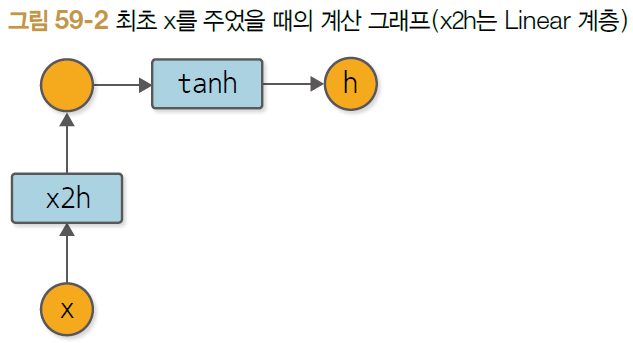


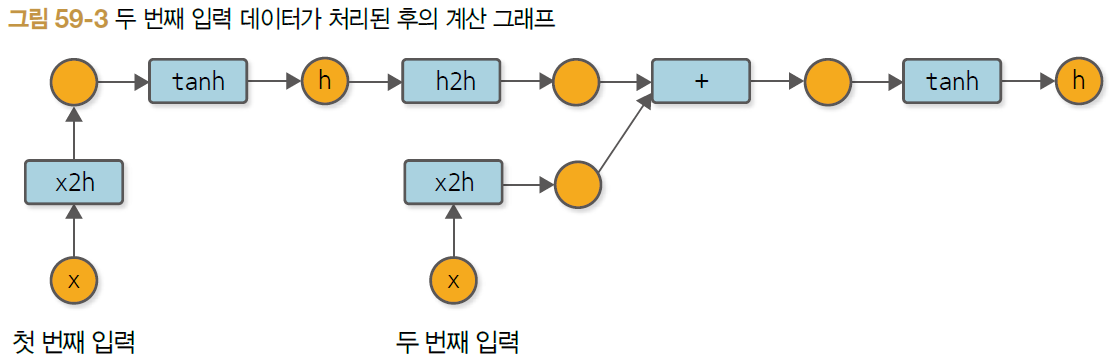

### 59.2 RNN 모델 구현

In [13]:
from dezero import Model 
import dezero.functions as F
import dezero.layers as L

class SimpleRNN(Model):
  def __init__(self, hidden_size, out_size):
    super().__init__()
    self.rnn = L.RNN(hidden_size)
    self.fc = L.Linear(out_size)

  def reset_state(self):
    self.rnn.reset_state()

  def forward(self, x):
    h = self.rnn(x)
    y = self.fc(h)
    return y


In [14]:
seq_data = [np.random.randn(1,1) for _ in range(1000)]
xs = seq_data[0:1]
ts = seq_data[1:]

model = SimpleRNN(10,1)

loss, cnt = 0, 0

for x, t in zip(xs,ts):
  y = model(x)
  loss += F.mean_squared_error(y, t)
  cnt += 1
  if cnt == 2:
    model.cleargrads()
    loss.backward()
    break
    

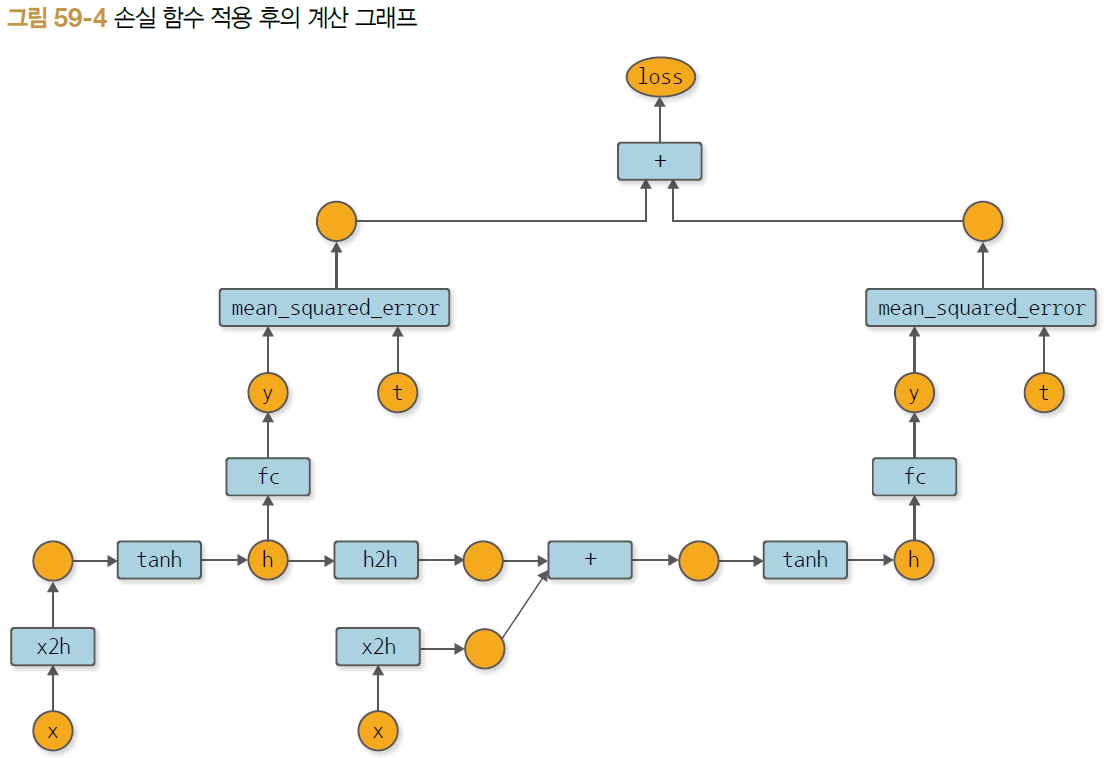

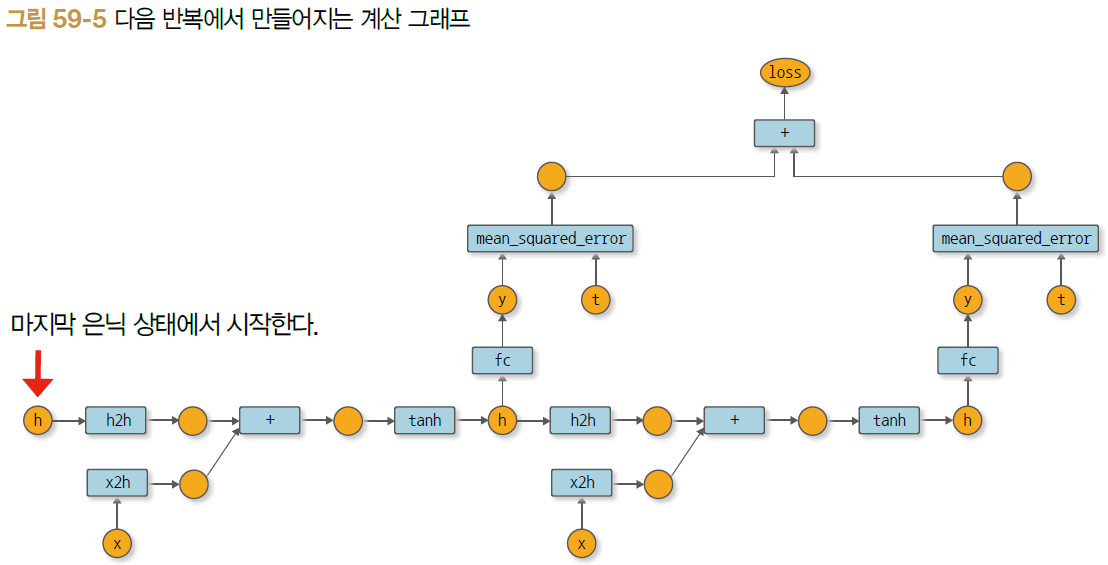

+ 계산 그래프가 만들어진 후로 loss.backward()를 통해 매개변수의 기울기를 구할 수 있음
+ BPTT(Backpropagation Throught Time)

### 59.3 '연결'을 끊어주는 메서드
+ 연결을 끊어줘야 할 때가 있다.
+ 만약 안 끊어주면 59.5를 적용하고 싶어도 하지 못한다. ( 59.4가 무조건 포함되어야하기 때문)

In [ ]:
class Variable:

  def unchain(self):
    self.creator = None

In [ ]:
class Variable:

  def unchain_backward(self):
    if self.creator is not None:
      funcs = [self.creator]
      while funcs:
        f = funcs.pop()
        for x in f.inputs:
          if x.creator is not None:
            funcs.append(x.creator)
            x.unchain()
            

### 59.4 사인파 예측

999
(array([-0.00561842]), array([-0.01304114]))
(array([-0.01304114]), array([-0.01176881]))
(array([-0.01176881]), array([0.0594588]))


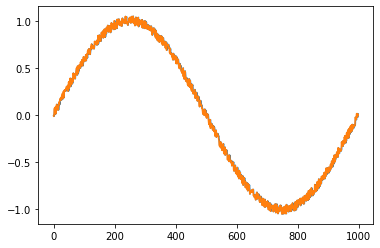

In [18]:
import numpy as np
import dezero
import matplotlib.pyplot as plt
train_set = dezero.datasets.SinCurve(train=True)
print(len(train_set))
print(train_set[0])
print(train_set[1])
print(train_set[2])

xs = [example[0] for example in train_set]
ts = [example[1] for example in train_set]
plt.plot(np.arange(len(xs)), xs, label='xs')
plt.plot(np.arange(len(ts)), ts, label='ts')
plt.show()

In [19]:
max_epoch = 100
hidden_size = 100
bptt_length = 30
train_set = dezero.datasets.SinCurve(train=True)
seqlen = len(train_set)

model = SimpleRNN(hidden_size, 1)
optimizer = dezero.optimizers.Adam().setup(model)

In [20]:
for epoch in range(max_epoch):
  model.reset_state()
  loss, count = 0, 0

  for x,t in train_set:
    x = x.reshape(1,1)
    y = model(x)
    loss += F.mean_squared_error(y, t)
    count += 1

    if count % bptt_length == 0 or count == seqlen:
      model.cleargrads()
      loss.backward()
      loss.unchain_backward()
      optimizer.update()


  avg_loss = float(loss.data)/count
  print('| epoch %d | loss %f' % (epoch+1, avg_loss))

| epoch 1 | loss 0.382874
| epoch 2 | loss 0.126372
| epoch 3 | loss 0.077218
| epoch 4 | loss 0.005178
| epoch 5 | loss 0.003280
| epoch 6 | loss 0.002619
| epoch 7 | loss 0.002345
| epoch 8 | loss 0.002183
| epoch 9 | loss 0.002082
| epoch 10 | loss 0.002033
| epoch 11 | loss 0.002034
| epoch 12 | loss 0.002093
| epoch 13 | loss 0.002233
| epoch 14 | loss 0.002485
| epoch 15 | loss 0.002917
| epoch 16 | loss 0.003594
| epoch 17 | loss 0.004539
| epoch 18 | loss 0.005584
| epoch 19 | loss 0.006335
| epoch 20 | loss 0.006530
| epoch 21 | loss 0.006385
| epoch 22 | loss 0.006261
| epoch 23 | loss 0.006276
| epoch 24 | loss 0.006348
| epoch 25 | loss 0.006373
| epoch 26 | loss 0.006312
| epoch 27 | loss 0.006198
| epoch 28 | loss 0.006084
| epoch 29 | loss 0.005997
| epoch 30 | loss 0.005938
| epoch 31 | loss 0.005898
| epoch 32 | loss 0.005869
| epoch 33 | loss 0.005851
| epoch 34 | loss 0.005849
| epoch 35 | loss 0.005867
| epoch 36 | loss 0.005908
| epoch 37 | loss 0.005976
| epoch 38

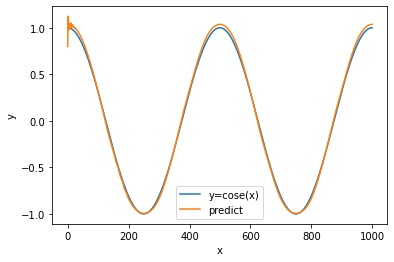

In [21]:
import matplotlib.pyplot as plt

xs = np.cos(np.linspace(0,4*np.pi, 1000))
model.reset_state()
pred_list = []

with dezero.no_grad():
  for x in xs:
    x = np.array(x).reshape(1,1)
    y = model(x)
    pred_list.append(float(y.data))

plt.plot(np.arange(len(xs)),xs,label='y=cose(x)')
plt.plot(np.arange(len(xs)), pred_list, label='predict')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()